#### Data Loading and cleaning

In [1]:
# Import libraries (add folium)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import Choropleth, Marker
import requests
import json
import os
import webbrowser
from matplotlib.ticker import MultipleLocator

# Enable inline plotting
%matplotlib inline

In [2]:
# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
# Load and clean datasets (run once if not already done)
def load_and_clean_data():
    df_athletes = pd.read_csv('athlete_events.csv')
    df_noc = pd.read_csv('noc_regions.csv')
    df = df_athletes.merge(df_noc[['NOC', 'region']], on='NOC', how='left')
    df.rename(columns={'region': 'Country'}, inplace=True)
    df['Medal'] = df['Medal'].fillna('None')
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['Height'] = df['Height'].fillna(df['Height'].median())
    df['Weight'] = df['Weight'].fillna(df['Weight'].median())
    country_map = {
        'United States': 'USA',
        'United Kingdom': 'Great Britain',
        'Russia': 'RUS',
        'South Korea': 'KOR',
        'North Korea': 'PRK',
        'Germany': 'DEU',
        'East Germany': 'DEU',  # Historical mapping
        'West Germany': 'DEU',
        'Soviet Union': 'URS',  # Historical
        'Czechoslovakia': 'CZE',
        # Add more mappings as needed for historical NOCs
    }
    df['Country'] = df['Country'].replace(country_map)
    df = df.drop_duplicates(subset=['ID', 'Event', 'Year', 'Medal'])
    return df

# Load data (run once)
df = load_and_clean_data()

In [4]:

df.head(15)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal,Country
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,None,China
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,None,China
2,3,Gunnar Nielsen Aaby,M,24.0,175.0,70.0,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,None,Denmark
3,4,Edgar Lindenau Aabye,M,34.0,175.0,70.0,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,None,Netherlands
5,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,"Speed Skating Women's 1,000 metres",None,Netherlands
6,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,Speed Skating Women's 500 metres,None,Netherlands
7,5,Christine Jacoba Aaftink,F,25.0,185.0,82.0,Netherlands,NED,1992 Winter,1992,Winter,Albertville,Speed Skating,"Speed Skating Women's 1,000 metres",None,Netherlands
8,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,Speed Skating Women's 500 metres,None,Netherlands
9,5,Christine Jacoba Aaftink,F,27.0,185.0,82.0,Netherlands,NED,1994 Winter,1994,Winter,Lillehammer,Speed Skating,"Speed Skating Women's 1,000 metres",None,Netherlands


In [5]:
# Check the range of years
min_year = df['Year'].min()
max_year = df['Year'].max()
print(f"Dataset covers years from {min_year} to {max_year}")

Dataset covers years from 1896 to 2016


#### 1. How many medals has Kenya won, and in which sports and events?

=== QUESTION 1: SPORTS WITH MOST KENYAN MEDALS ===
=== SPORTS WITH KENYAN OLYMPIC MEDALS (1956-2024) ===
Total Sports with Medals: 2
Medal Counts by Sport:
Sport
Athletics    99
Boxing        7
Name: ID, dtype: int64


C:\Users\user\AppData\Local\Temp\ipykernel_36652\2853917309.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sport_medals.index[:top_n], y=sport_medals.values[:top_n], palette='viridis')


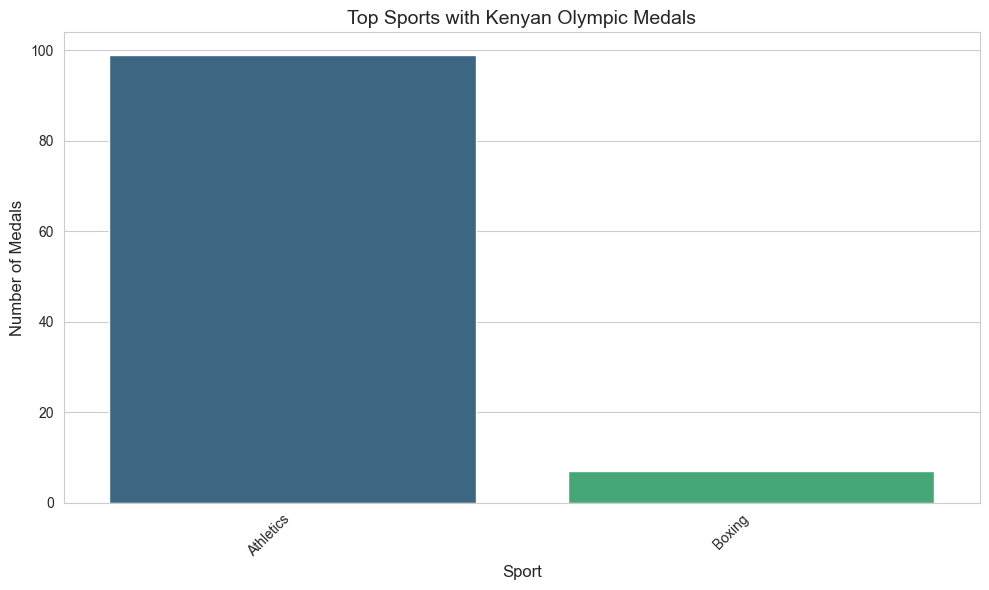

In [6]:
def q1_sports_with_most_kenyan_medals():
    # Filter for Kenyan medalists
    kenya_medals = df[(df['NOC'] == 'KEN') & (df['Medal'] != 'None')]
    
    # Count medals per sport
    sport_medals = kenya_medals.groupby('Sport')['ID'].count().sort_values(ascending=False)
    
    # Print all sports with medals
    print("=== SPORTS WITH KENYAN OLYMPIC MEDALS (1956-2024) ===")
    print(f"Total Sports with Medals: {len(sport_medals)}")
    print("Medal Counts by Sport:")
    print(sport_medals)
    
    # Bar plot for top 5 sports (or all if fewer)
    top_n = min(5, len(sport_medals))  # Show top 5 or all if less than 5
    plt.figure(figsize=(10, 6))
    sns.barplot(x=sport_medals.index[:top_n], y=sport_medals.values[:top_n], palette='viridis')
    plt.title('Top Sports with Kenyan Olympic Medals', fontsize=14)
    plt.xlabel('Sport', fontsize=12)
    plt.ylabel('Number of Medals', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.tight_layout()
    plt.savefig('kenya_top_sports_medals.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Return top 5 for further use
    return sport_medals.head(top_n)

# Run Question 1
print("=== QUESTION 1: SPORTS WITH MOST KENYAN MEDALS ===")
top_sports = q1_sports_with_most_kenyan_medals()

#### 2. How have Kenya’s medal counts evolved over time (1956–2024)?

=== QUESTION 2: KENYA'S MEDAL TRENDS ===


NameError: name 'index' is not defined

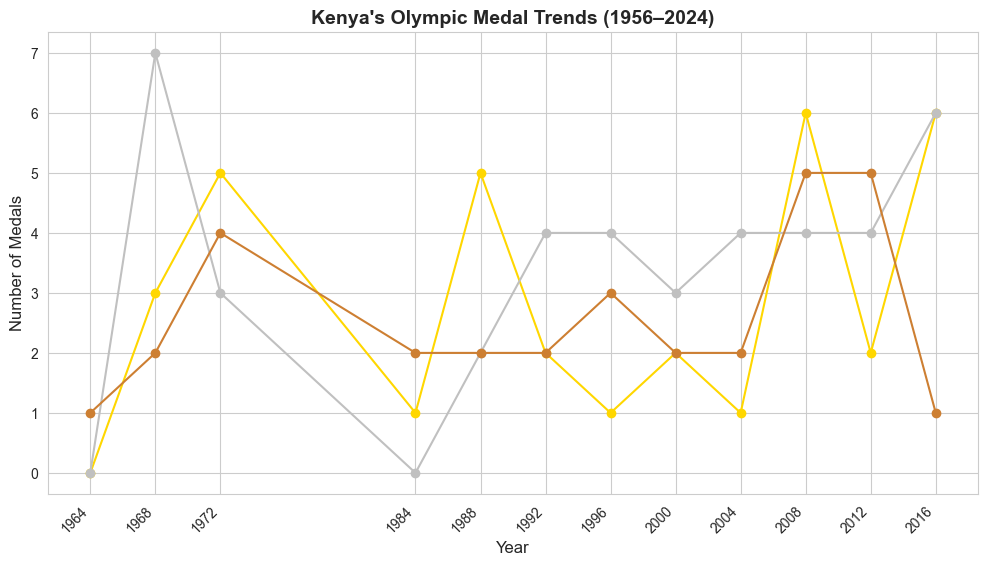

In [7]:
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter

def q2_kenya_medal_trends():
    # Filter for Kenyan medals
    kenya_df = df[(df['NOC'] == 'KEN') & (df['Medal'] != 'None')]
    
    # Group by year and medal type
    medal_trends = kenya_df.groupby(['Year', 'Medal'])['ID'].count().unstack(fill_value=0)
    
    # Ensure all medal types are present
    medal_types = ['Bronze', 'Silver', 'Gold']
    medal_trends = medal_trends.reindex(columns=medal_types, fill_value=0)
    
    # Prepare data for plotting
    years = medal_trends.index
    gold_medals = medal_trends['Gold']
    silver_medals = medal_trends['Silver']
    bronze_medals = medal_trends['Bronze']
    
    # Create line plot
    plt.figure(figsize=(12, 6))
    
    # Plot lines for each medal type
    plt.plot(years, gold_medals, label='Gold', marker='o', color='gold')
    plt.plot(years, silver_medals, label='Silver', marker='o', color='silver')
    plt.plot(years, bronze_medals, label='Bronze', marker='o', color='#CD7F32')  # Bronze color
    
    # Customize the plot
    plt.title("Kenya's Olympic Medal Trends (1956–2024)", fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Medals', fontsize=12)
    plt.xticks(years, rotation=45, ha='right', fontsize=10)  # Major ticks at Olympic years
    
    # Add minor ticks for years between major ticks
    minor_years = []
    for i in range(len(years) - 1):
        start_year = years[i]
        end_year = years[i + 1]
        minor_years.extend(range(start_year + 1, end_year))
    minor_positions = [index[years.get_loc(y)] + (index[years.get_loc(y + 1)] - index[years.get_loc(y)]) * (j + 1) / 4 
                      for y in years[:-1] for j in range(3)]  # 3 minor ticks per 4-year gap
    
    ax = plt.gca()  # Get current axes
    ax.xaxis.set_minor_locator(FixedLocator(minor_positions))
    ax.xaxis.set_minor_formatter(FixedFormatter([str(y) for y in minor_years]))
    ax.tick_params(axis='x', which='minor', length=4, labelsize=8)  # Labels on minor ticks
    
    plt.grid(True, alpha=0.3, linestyle='--')
    plt.legend(title='Medal Type', loc='upper left', fontsize=10, title_fontsize=11)
    
    plt.tight_layout()
    plt.savefig('kenya_medal_trends.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print medal summary
    print("=== KENYA'S MEDAL TRENDS (1956–2024) ===")
    for year in years:
        print(f"Year {year}: Gold={gold_medals[year]}, Silver={silver_medals[year]}, Bronze={bronze_medals[year]}")
    
    return medal_trends

# Run Question 2
print("=== QUESTION 2: KENYA'S MEDAL TRENDS ===")
kenya_trends = q2_kenya_medal_trends()

In [ ]:
# Filter for Kenyan data
kenya_df = df[df['NOC'] == 'KEN']

# Check all years with participation (medals or not)
print("=== KENYA PARTICIPATION AND MEDALS BY YEAR ===")
participation = kenya_df.groupby(['Year', 'Medal'])['ID'].count().unstack(fill_value=0)
print(participation)

# Specifically check 1976 and 1980
years_to_check = [1976, 1980]
for year in years_to_check:
    year_data = kenya_df[kenya_df['Year'] == year]
    if year_data.empty:
        print(f"\nYear {year}: No Kenyan participation (likely boycotted)")
    else:
        medals = year_data[year_data['Medal'] != 'None'].groupby('Medal')['ID'].count()
        print(f"\nYear {year}: Kenyan participation found")
        print("Medal counts:")
        print(medals)

# Check all Kenyan athletes (even without medals) for those years
for year in years_to_check:
    athletes = kenya_df[kenya_df['Year'] == year]['ID'].nunique()
    
    print(f"Year {year}: Total unique Kenyan athletes = {athletes}")

=== KENYA PARTICIPATION AND MEDALS BY YEAR ===
Medal  Bronze  Gold  None  Silver
Year                             
1956        0     0    31       0
1960        0     0    30       0
1964        1     0    40       0
1968        2     3    38       7
1972        4     5    57       3
1984        2     1    64       0
1988        2     5    79       2
1992        2     2    47       4
1996        3     1    46       4
1998        0     0     1       0
2000        2     2    52       3
2002        0     0     2       0
2004        2     1    39       4
2006        0     0     1       0
2008        5     6    32       4
2012        5     2    40       4
2016        1     6    67       6

Year 1976: No Kenyan participation (likely boycotted)

Year 1980: No Kenyan participation (likely boycotted)
Year 1976: Total unique Kenyan athletes = 0
Year 1980: Total unique Kenyan athletes = 0


#### 3. What are the typical age and gender profiles of Kenyan medalists?

QUESTION 3: KENYAN MEDALISTS - AGE & GENDER PROFILES
 KENYAN OLYMPIC MEDALISTS PROFILE (1956-2024) 
Total Kenyan Medalists: 106
Time Period: 1964 - 2016



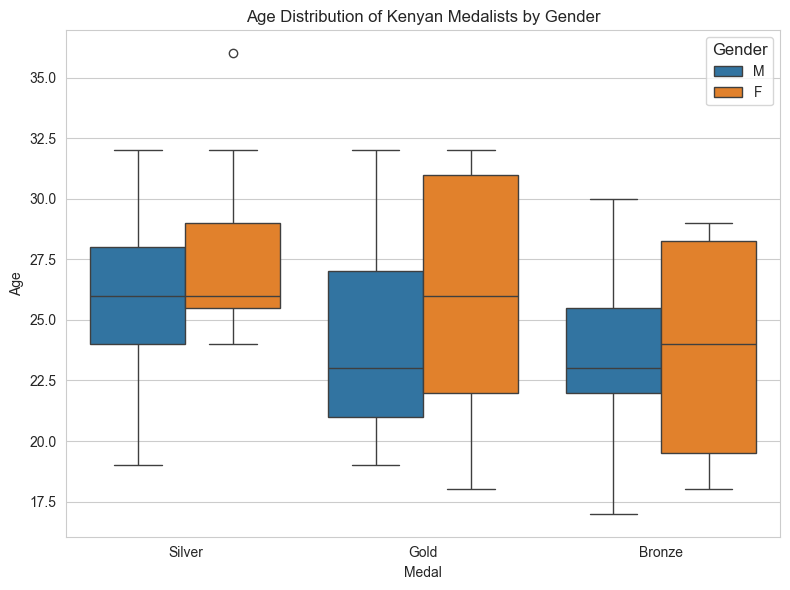

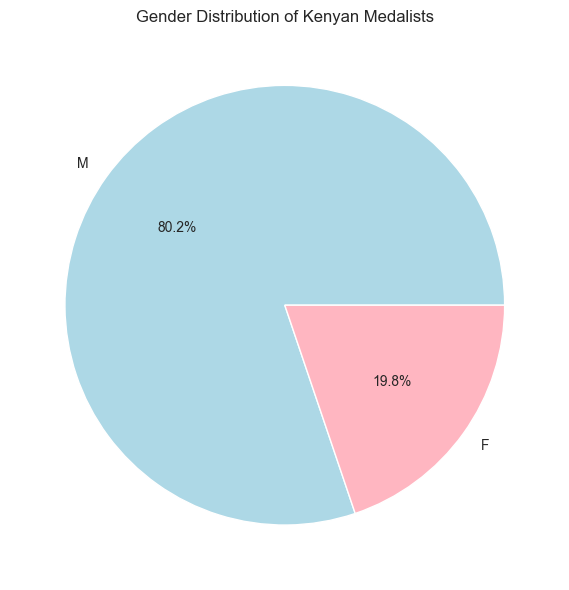

=== AGE DISTRIBUTION ANALYSIS ===
Age Statistics (All Kenyan Medalists):
  Count: 106
  Mean: 25.0 years
  Median: 24.5 years
  Range: 17 - 36 years
  IQR: 22.0 - 28.0 years

Age by Gender:
  M (85 athletes): Mean = 24.7, Median = 24.0
  F (21 athletes): Mean = 26.5, Median = 26.0

Age by Medal Type:
  Gold (34 medals): Mean = 24.7, Median = 23.5
  Silver (41 medals): Mean = 26.3, Median = 26.0
  Bronze (31 medals): Mean = 23.7, Median = 23.0

 GENDER COMPOSITION ANALYSIS 
Total Medalists: 106

M Athletes: 85 (80.2%)
F Athletes: 21 (19.8%)

GENDER INSIGHT: Male dominance (80.2%) - likely due to historical focus on men's distance running

 HISTORICAL TRENDS 
Recent Gender Participation (Last 3 Olympics):
  2008: 9M, 6F (40.0% female)
  2012: 7M, 4F (36.4% female)
  2016: 6M, 7F (53.8% female)

First Female Medalist: 1996
  Pre-2000: 1 female medalists
  2000+: 20 female medalists
  TREND: Significant increase in female medal success post-2000

 KEY INSIGHTS 
• Peak Performance Age: 28 y

In [ ]:
def q3_kenya_athlete_profiles():
    kenya_medals = df[(df['NOC'] == 'KEN') & (df['Medal'] != 'None')]
    
    # Print basic overview
    total_medalists = len(kenya_medals)
    print(f" KENYAN OLYMPIC MEDALISTS PROFILE (1956-2024) ")
    print(f"Total Kenyan Medalists: {total_medalists}")
    print(f"Time Period: {kenya_medals['Year'].min()} - {kenya_medals['Year'].max()}")
    print()
    
    # Boxplot: Age distribution
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Medal', y='Age', hue='Sex', data=kenya_medals)
    plt.title("Age Distribution of Kenyan Medalists by Gender")
    plt.tight_layout()
    plt.legend(title='Gender', loc='upper right', fontsize=10, title_fontsize=12, frameon=True)
    plt.savefig('kenya_medalist_age_boxplot.png')
    plt.show()
    
    # Pie chart: Gender composition
    gender_counts = kenya_medals['Sex'].value_counts()
    plt.figure(figsize=(6, 6))
    plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', colors=['lightblue', 'lightpink'])
    plt.title("Gender Distribution of Kenyan Medalists")
    plt.tight_layout()
    plt.savefig('kenya_medalist_gender_pie.png')
    plt.show()
    
    #  AGE ANALYSIS 
    print("=== AGE DISTRIBUTION ANALYSIS ===")
    age_stats = kenya_medals['Age'].describe()
    print(f"Age Statistics (All Kenyan Medalists):")
    print(f"  Count: {int(age_stats['count'])}")
    print(f"  Mean: {age_stats['mean']:.1f} years")
    print(f"  Median: {age_stats['50%']:.1f} years")
    print(f"  Range: {int(age_stats['min'])} - {int(age_stats['max'])} years")
    print(f"  IQR: {age_stats['25%']:.1f} - {age_stats['75%']:.1f} years")
    print()
    
    # Age by gender
    print("Age by Gender:")
    for sex in ['M', 'F']:
        sex_data = kenya_medals[kenya_medals['Sex'] == sex]
        if len(sex_data) > 0:
            sex_age_stats = sex_data['Age'].describe()
            print(f"  {sex} ({len(sex_data)} athletes): Mean = {sex_age_stats['mean']:.1f}, Median = {sex_age_stats['50%']:.1f}")
    print()
    
    # Age by medal type
    print("Age by Medal Type:")
    medal_age_stats = kenya_medals.groupby('Medal')['Age'].agg(['count', 'mean', 'median']).round(1)
    for medal in ['Gold', 'Silver', 'Bronze']:
        if medal in medal_age_stats.index:
            row = medal_age_stats.loc[medal]
            print(f"  {medal} ({int(row['count'])} medals): Mean = {row['mean']:.1f}, Median = {row['median']:.1f}")
    print()
    
    #  GENDER ANALYSIS 
    print(" GENDER COMPOSITION ANALYSIS ")
    total_medalists = gender_counts.sum()
    print(f"Total Medalists: {total_medalists}")
    print()
    
    for sex, count in gender_counts.items():
        percentage = (count / total_medalists) * 100
        print(f"{sex} Athletes: {count} ({percentage:.1f}%)")
    
    # Gender dominance analysis
    male_count = gender_counts.get('M', 0)
    female_count = gender_counts.get('F', 0)
    male_percentage = (male_count / total_medalists) * 100 if total_medalists > 0 else 0
    
    if male_percentage > 70:
        print(f"\nGENDER INSIGHT: Male dominance ({male_percentage:.1f}%) - likely due to historical focus on men's distance running")
    elif male_percentage > 60:
        print(f"\nGENDER INSIGHT: Male majority ({male_percentage:.1f}%) - gradual improvement in women's participation")
    elif male_percentage > 50:
        print(f"\nGENDER INSIGHT: Slight male majority ({male_percentage:.1f}%) - approaching gender balance")
    else:
        print(f"\nGENDER INSIGHT: Gender balance achieved ({male_percentage:.1f}% male)")
    
    # HISTORICAL TRENDS 
    print("\n HISTORICAL TRENDS ")
    # Gender participation over time
    gender_trends = kenya_medals.groupby(['Year', 'Sex']).size().unstack(fill_value=0)
    if not gender_trends.empty:
        recent_years = gender_trends.tail(3)  # Last 3 Olympics
        print("Recent Gender Participation (Last 3 Olympics):")
        for year in recent_years.index:
            male_year = recent_years.loc[year, 'M'] if 'M' in recent_years.columns else 0
            female_year = recent_years.loc[year, 'F'] if 'F' in recent_years.columns else 0
            total_year = male_year + female_year
            if total_year > 0:
                female_pct_year = (female_year / total_year) * 100
                print(f"  {year}: {male_year}M, {female_year}F ({female_pct_year:.1f}% female)")
        
        # Trend analysis
        first_year_female = kenya_medals[kenya_medals['Sex'] == 'F']['Year'].min()
        if pd.notna(first_year_female):
            print(f"\nFirst Female Medalist: {first_year_female}")
            early_females = len(kenya_medals[(kenya_medals['Sex'] == 'F') & (kenya_medals['Year'] < 2000)])
            recent_females = len(kenya_medals[(kenya_medals['Sex'] == 'F') & (kenya_medals['Year'] >= 2000)])
            print(f"  Pre-2000: {early_females} female medalists")
            print(f"  2000+: {recent_females} female medalists")
            if recent_females > early_females * 2:
                print("  TREND: Significant increase in female medal success post-2000")
    
    #  KEY INSIGHTS 
    print("\n KEY INSIGHTS ")
    print(f"• Peak Performance Age: {int(age_stats['75%'])} years (top quartile)")
    print(f"• Most Common Age Range: {int(age_stats['25%'])}-{int(age_stats['75%'])} years")
    print(f"• Gender Gap: {abs(male_percentage - 50):.1f}% from perfect balance")
    
    if male_percentage > 60:
        print("• RECOMMENDATION: Continue investing in women's athletics programs")
    else:
        print("• ACHIEVEMENT: Near gender parity in medal success")
    
    print("\n" + "="*60)
    
    return age_stats, gender_counts

# Run Question 3
print("QUESTION 3: KENYAN MEDALISTS - AGE & GENDER PROFILES")
age_stats, gender_counts = q3_kenya_athlete_profiles()

#### 4. Which events does Kenya dominate compared to other countries?

In [ ]:
def q4_kenya_event_dominance():
    medal_events = df[df['Medal'] != 'None'].groupby(['Event', 'NOC'])['ID'].count().unstack(fill_value=0)
    kenya_events = medal_events['KEN'].sort_values(ascending=False).head(5)
    
    # Bar chart: Top Kenyan events
    plt.figure(figsize=(12, 6))
    kenya_events.plot(kind='bar', color='green')
    plt.title("Top 5 Medal-Winning Events for Kenya")
    plt.xlabel('Event')
    plt.ylabel('Number of Medals')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('kenya_top_events.png')
    plt.show()
    
    return kenya_events

Kenya's Dominant Events:


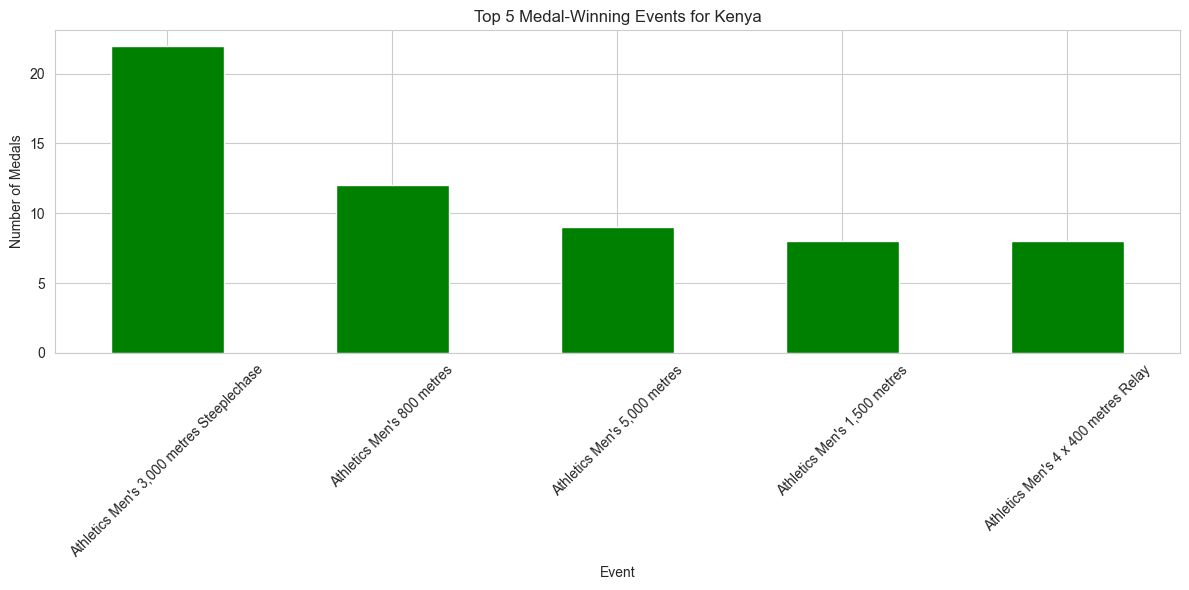

Event
Athletics Men's 3,000 metres Steeplechase    22
Athletics Men's 800 metres                   12
Athletics Men's 5,000 metres                  9
Athletics Men's 1,500 metres                  8
Athletics Men's 4 x 400 metres Relay          8
Name: KEN, dtype: int64


In [ ]:
print("Kenya's Dominant Events:")
kenya_events = q4_kenya_event_dominance()
print(kenya_events)

#### 5. Is there a time African countries were doing better than Kenya?

KeyError: 1909

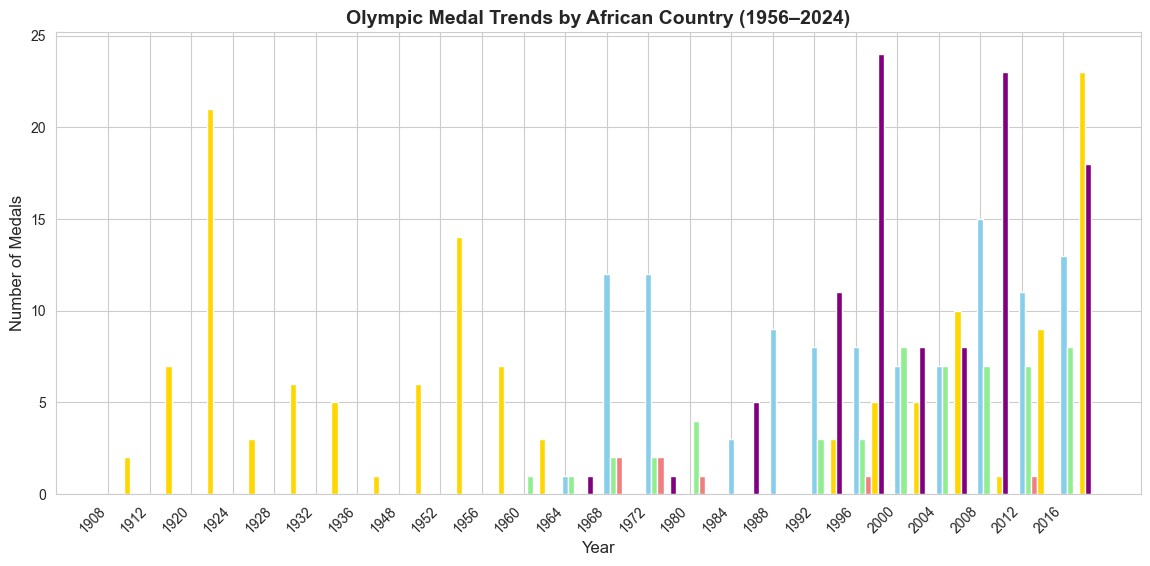

In [ ]:
from matplotlib.ticker import MultipleLocator, FixedLocator, FixedFormatter

def q5_african_comparison():
    # Define African countries with full names and colors
    african_countries = {
        'KEN': {'name': 'Kenya', 'color': 'skyblue'},
        'ETH': {'name': 'Ethiopia', 'color': 'lightgreen'},
        'UGA': {'name': 'Uganda', 'color': 'lightcoral'},
        'RSA': {'name': 'South Africa', 'color': 'gold'},
        'NGR': {'name': 'Nigeria', 'color': 'purple'}
    }
    african_nocs = list(african_countries.keys())
    
    # Filter dataset
    african_df = df[df['NOC'].isin(african_nocs) & (df['Medal'] != 'None')]
    
    # Group by year and NOC to get medal counts per year
    medal_counts = african_df.groupby(['Year', 'NOC'])['ID'].count().unstack(fill_value=0)
    medal_counts = medal_counts.reindex(columns=african_nocs, fill_value=0)
    
    # Prepare data for plotting
    years = medal_counts.index
    countries = [african_countries[noc]['name'] for noc in african_nocs]
    colors = [african_countries[noc]['color'] for noc in african_nocs]
    medal_data = medal_counts.values
    
    # Create grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 6))
    bar_width = 0.15
    index = range(len(years))
    
    # Plot bars for each country with defined colors
    for i, country in enumerate(countries):
        plt.bar([x + i * bar_width for x in index], medal_data[:, i], 
                bar_width, label=country, color=colors[i])
    
    # Customize the plot
    plt.title('Olympic Medal Trends by African Country (1956–2024)', fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Medals', fontsize=12)
    plt.xticks(index, years, rotation=45, ha='right', fontsize=10)  # Major ticks at Olympic years
    
    # Define minor ticks for years between major ticks
    minor_years = []
    for i in range(len(years) - 1):
        start_year = years[i]
        end_year = years[i + 1]
        minor_years.extend(range(start_year + 1, end_year))
    minor_positions = [index[years.get_loc(y)] + (index[years.get_loc(y + 1)] - index[years.get_loc(y)]) * (j + 1) / 4 
                      for y in years[:-1] for j in range(3)]  # 3 minor ticks per 4-year gap
    
    ax.xaxis.set_minor_locator(FixedLocator(minor_positions))
    ax.xaxis.set_minor_formatter(FixedFormatter([str(y) for y in minor_years]))
    ax.tick_params(axis='x', which='minor', length=4, labelsize=8)  # Labels on minor ticks
    
    plt.grid(True, axis='y', alpha=0.3, linestyle='--')
    
    # Add legend with color-country mapping
    plt.legend(title='Country (Color)', loc='upper left', fontsize=10, title_fontsize=11, frameon=True,
               handlelength=1.5, labelspacing=0.5)
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.savefig('african_medal_trends_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print medal summary
    print("=== MEDAL SUMMARY FOR AFRICAN COUNTRIES (1956–2024) ===")
    for noc in african_nocs:
        total_medals = medal_counts[noc].sum()
        print(f"{african_countries[noc]['name']} (NOC: {noc}): {total_medals} medals")
    
    return medal_counts
q5_african_comparison()


#### 6. Underdog sports Kenya tried beyond athletics

In [ ]:
def q6_kenya_underdog_sports():
    kenya_non_athletics = df[(df['NOC'] == 'KEN') & (df['Sport'] != 'Athletics')]
    non_athletics_medals = kenya_non_athletics[kenya_non_athletics['Medal'] != 'None'].groupby('Sport')['ID'].count()
    participation = kenya_non_athletics['Sport'].value_counts()
    
    # Bar chart: Participation in non-athletics sports
    plt.figure(figsize=(10, 6))
    participation.plot(kind='bar', color='orange')
    plt.title("Kenya's Participation in Non-Athletics Sports")
    plt.xlabel('Sport')
    plt.ylabel('Number of Athletes')
    plt.tight_layout()
    plt.savefig('kenya_non_athletics_participation.png')
    plt.show()
    
    return non_athletics_medals, participation


Question 6: Kenya's Underdog Sports


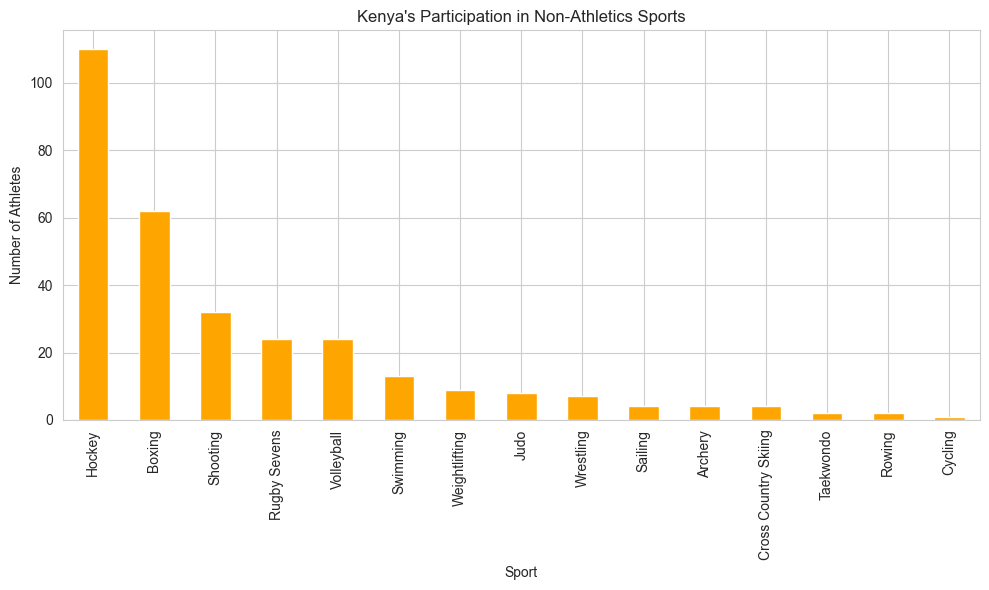

Non-Athletics Medals:
Sport
Boxing    7
Name: ID, dtype: int64

Participation in Non-Athletics Sports:
Sport
Hockey                  110
Boxing                   62
Shooting                 32
Rugby Sevens             24
Volleyball               24
Swimming                 13
Weightlifting             9
Judo                      8
Wrestling                 7
Sailing                   4
Archery                   4
Cross Country Skiing      4
Taekwondo                 2
Rowing                    2
Cycling                   1
Name: count, dtype: int64


In [ ]:
print("\nQuestion 6: Kenya's Underdog Sports")
non_athletics_medals, participation = q6_kenya_underdog_sports()
print("Non-Athletics Medals:")
print(non_athletics_medals)
print("\nParticipation in Non-Athletics Sports:")
print(participation)

#### 7. Does Kenya’s medal efficiency outrank other nations?

Question 7: Enhanced Medal Efficiency (2000–2016)
Top Countries by Medal Efficiency (2000–2016):
        Country  Efficiency
0           USA       0.630
1       Jamaica       0.625
2        Norway       0.510
3           RUS       0.500
4   Netherlands       0.472
5           DEU       0.446
6       Bahamas       0.411
7     Australia       0.389
8         China       0.384
9        Serbia       0.374
10     Paraguay       0.370
11       Sweden       0.360
12         Cuba       0.353
13           UK       0.349
14      Denmark       0.333
15      Finland       0.332
16     Ethiopia       0.330
17       Canada       0.327
18          KOR       0.323
19      Romania       0.302
20      Croatia       0.302
21       France       0.294
22        Italy       0.290
23      Hungary       0.285
24       Brazil       0.283
31        Kenya       0.240

Kenya's Efficiency (2000–2016): 0.240


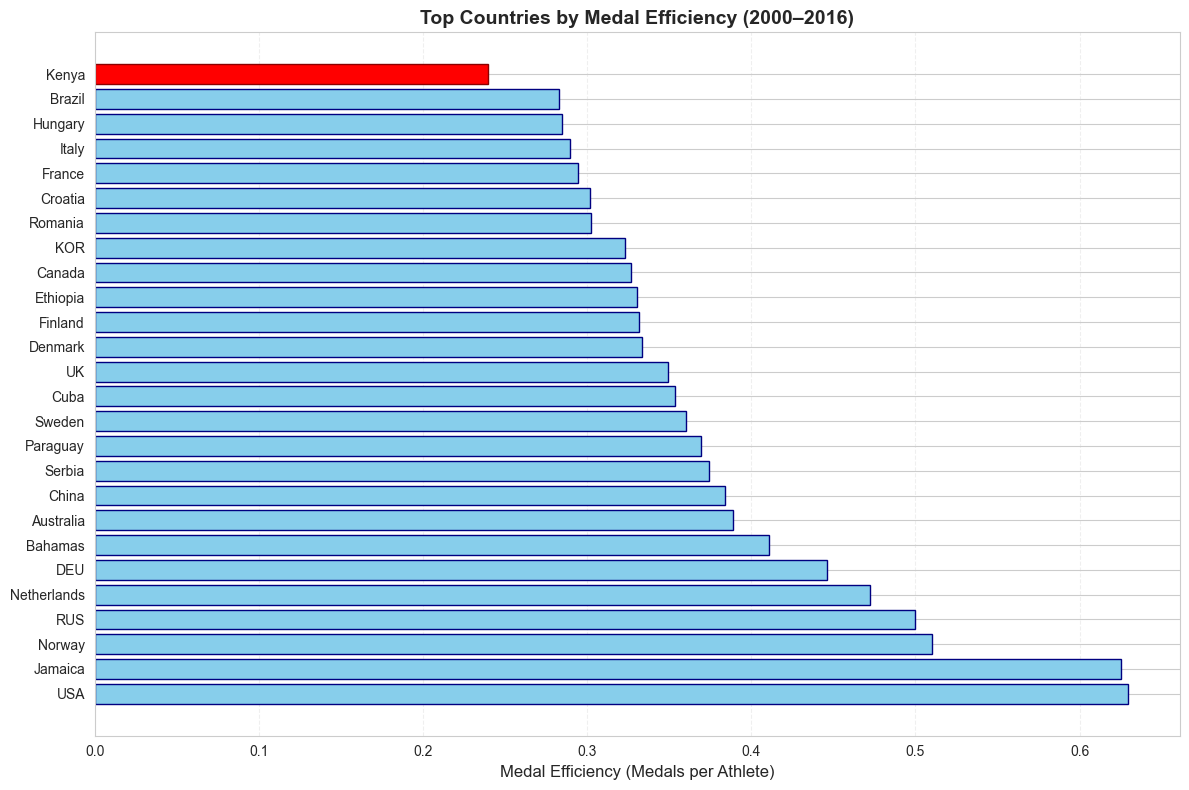

In [ ]:
def q7_medal_efficiency():
    # Filter dataset for years 2000 to 2016
    df_filtered = df[(df['Year'] >= 2000) & (df['Year'] <= 2016)]
    
    # Calculate medals and athletes per country for the filtered period
    medals = df_filtered[df_filtered['Medal'] != 'None'].groupby('NOC')['ID'].count()
    athletes = df_filtered.groupby('NOC')['ID'].nunique()
    efficiency = (medals / athletes).dropna().sort_values(ascending=False)
    
    # Convert NOC to country names
    efficiency_df = pd.DataFrame({
        'NOC': efficiency.index,
        'Efficiency': efficiency.values
    })
    efficiency_df = efficiency_df.merge(df[['NOC', 'Country']].drop_duplicates(), on='NOC', how='left')
    
    # Get top 25 (to ensure Kenya is likely included) and Kenya specifically
    top_25_eff = efficiency_df.head(25)
    kenya_eff = efficiency_df[efficiency_df['Country'].str.contains('Kenya', case=False, na=False)]
    
    # Ensure Kenya is in the list, even if not in top 25
    if not kenya_eff.empty and kenya_eff.index[0] not in top_25_eff.index:
        top_25_eff = pd.concat([top_25_eff, kenya_eff]).drop_duplicates().sort_values('Efficiency', ascending=False)
    
    print("Top Countries by Medal Efficiency (2000–2016):")
    print(top_25_eff[['Country', 'Efficiency']].round(3))
    print(f"\nKenya's Efficiency (2000–2016): {kenya_eff['Efficiency'].iloc[0]:.3f}" if not kenya_eff.empty else "\nKenya not found in data")
    
    # Create horizontal bar chart
    plt.figure(figsize=(12, 8))
    y_pos = range(len(top_25_eff))
    
    # Plot all top 25 with Kenya highlighted
    bars = plt.barh(y_pos, top_25_eff['Efficiency'], align='center', color='skyblue', edgecolor='navy')
    if not kenya_eff.empty:
        kenya_idx = top_25_eff.index[top_25_eff['NOC'] == kenya_eff['NOC'].iloc[0]]
        if len(kenya_idx) > 0:
            bars[top_25_eff.index.get_loc(kenya_idx[0])].set_color('red')
            bars[top_25_eff.index.get_loc(kenya_idx[0])].set_edgecolor('darkred')
    
    plt.yticks(y_pos, top_25_eff['Country'], fontsize=10)
    plt.xlabel('Medal Efficiency (Medals per Athlete)', fontsize=12)
    plt.title('Top Countries by Medal Efficiency (2000–2016)', fontsize=14, fontweight='bold')
    plt.grid(True, axis='x', alpha=0.3, linestyle='--')
    
    # Customize layout
    plt.tight_layout()
    plt.savefig('medal_efficiency_top25_2000_2016.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return efficiency.head(10), efficiency.get('KEN', 0)

# Run Question 7
print("Question 7: Enhanced Medal Efficiency (2000–2016)")
top_efficiency, kenya_efficiency = q7_medal_efficiency()

#### 8. How are Olympic medals distributed geographically? with Folium map

In [ ]:
def q8_global_medal_map_folium():
    # Aggregate medals by country
    global_medals = df[df['Medal'] != 'None'].groupby(['Country', 'NOC']).agg({
        'ID': 'count'
    }).reset_index()
    global_medals.columns = ['Country', 'NOC', 'Total_Medals']
    total_countries = len(global_medals)
    print(f"Total countries with medals: {total_countries}")
    
    # Calculate efficiency for marker sizing
    athletes = df.groupby('NOC')['ID'].nunique()
    global_medals = global_medals.merge(athletes.rename('Total_Athletes'), left_on='NOC', right_index=True, how='left')
    global_medals['Efficiency'] = global_medals['Total_Medals'] / global_medals['Total_Athletes']
    global_medals = global_medals.fillna(0)
    
    # Fetch and load GeoJSON for country boundaries
    geojson_url = 'https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json'
    response = requests.get(geojson_url)
    if response.status_code != 200:
        raise ValueError(f"Failed to fetch GeoJSON: Status code {response.status_code}")
    geojson_data = response.json()
    
    # Create country to coordinates mapping (simplified - using approximate centroids)
    country_coords = {
        'United States': [37.0902, -95.7129],
        'Russia': [61.5240, 105.3188],
        "People's Republic of China": [35.8617, 104.1954],
        'United Kingdom': [55.3781, -3.4360],
        'Germany': [51.1657, 10.4515],
        'France': [46.2276, 2.2137],
        'Italy': [41.8719, 12.5674],
        'Japan': [36.2048, 138.2529],
        'Australia': [-25.2744, 133.7751],
        'Canada': [56.1304, -106.3468],
        'Spain': [40.4637, -3.7492],
        'Netherlands': [52.1326, 5.2913],
        'Sweden': [60.1282, 18.6435],
        'Hungary': [47.1625, 19.5033],
        'Kenya': [-1.2921, 36.8219],
        'Ethiopia': [9.1450, 40.4897],
        'South Africa': [-30.5595, 22.9375],
        'Cuba': [21.5218, -77.7812],
        'Romania': [45.9432, 24.9668],
        'Poland': [51.9194, 19.1451],
        # Add more as needed based on your top countries
    }
    
    # Initialize Folium map
    folium_map = folium.Map(location=[0, 0], zoom_start=2, tiles='OpenStreetMap')
    print("Folium map initialized with markers for all countries.")
    
    # Add markers for all countries with medals
    marker_count = 0
    for _, country in global_medals.iterrows():
        country_name = country['Country']
        medals = country['Total_Medals']
        efficiency = country['Efficiency']
        
        # Get coordinates (use default if not in mapping)
        coords = country_coords.get(country_name, [20, 0])  # Default to approximate global center
        
        if medals > 0:  # Only add markers for countries with medals
            # Color based on medal count
            if medals >= 1000:
                color = 'darkred'
            elif medals >= 500:
                color = 'red'
            elif medals >= 100:
                color = 'orange'
            elif medals >= 50:
                color = 'yellow'
            elif medals >= 10:
                color = 'lightgreen'
            else:
                color = 'green'
            
            # Size based on efficiency
            size = max(8, min(20, int(efficiency * 1000)))  # Scale efficiency to marker size
            
            # Create marker
            folium.CircleMarker(
                location=coords,
                radius=size,
                popup=folium.Popup(f"""
                    <b>{country_name}</b><br>
                    Total Medals: {medals}<br>
                    Athletes: {int(country['Total_Athletes'])}<br>
                    Efficiency: {efficiency:.3f} medals/athlete<br>
                    NOC: {country['NOC']}
                """, max_width=300),
                tooltip=f"{country_name}: {medals} medals",
                color=color,
                fill=True,
                fillColor=color,
                fillOpacity=0.7,
                weight=1
            ).add_to(folium_map)
            marker_count += 1
    
    # Special highlight for Kenya
    kenya_data = global_medals[global_medals['Country'].str.contains('Kenya', case=False, na=False)]
    if not kenya_data.empty:
        kenya_coords = [-1.2921, 36.8219]
        kenya_medals = kenya_data['Total_Medals'].iloc[0]
        kenya_efficiency = kenya_data['Efficiency'].iloc[0]
        
        folium.Marker(
            location=kenya_coords,
            popup=folium.Popup(f"""
                <b>🇰🇪 KENYA (Special Highlight)</b><br>
                Total Medals: {kenya_medals}<br>
                Athletes: {int(kenya_data['Total_Athletes'].iloc[0])}<br>
                Efficiency: {kenya_efficiency:.3f} medals/athlete<br>
                <b>Top African Nation!</b>
            """, max_width=300),
            tooltip=f"Kenya: {kenya_medals} medals ({kenya_efficiency:.3f} efficiency)",
            icon=folium.Icon(color='red', icon='star', prefix='fa', icon_color='gold')
        ).add_to(folium_map)
        print(f"Kenya highlighted: {kenya_medals} medals, {kenya_efficiency:.3f} efficiency")
    
    # Add legend for marker colors
    legend_html = '''
    <div style="position: fixed; 
                bottom: 50px; left: 50px; width: 200px; height: 140px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px">
    <b>Medal Count Legend</b><br>
    <i class="fa fa-circle" style="color:darkred"></i> 1000+ medals<br>
    <i class="fa fa-circle" style="color:red"></i> 500-999 medals<br>
    <i class="fa fa-circle" style="color:orange"></i> 100-499 medals<br>
    <i class="fa fa-circle" style="color:yellow"></i> 50-99 medals<br>
    <i class="fa fa-circle" style="color:lightgreen"></i> 10-49 medals<br>
    <i class="fa fa-circle" style="color:green"></i> 1-9 medals<br>
    <i class="fa fa-star" style="color:red"></i> Kenya (Highlighted)
    </div>
    '''
    folium_map.get_root().html.add_child(folium.Element(legend_html))
    
    # Save and display
    folium_map.save('global_medal_map_all_markers.html')
    print(f"Map with {marker_count} country markers saved to {os.path.abspath('global_medal_map_all_markers.html')}")
    
    try:
        display(folium_map._repr_html_())
        print("Map displayed inline successfully.")
    except Exception as e:
        print(f"Error displaying map inline: {e}")
        print("Please open the saved HTML file in a web browser.")
        webbrowser.open(f'file://{os.path.abspath("global_medal_map_all_markers.html")}')
    
    # Static bar chart for top 20 (unchanged from previous)
    top_20 = global_medals.sort_values('Total_Medals', ascending=False).head(20)
    plt.figure(figsize=(14, 6))
    sns.barplot(x='Country', y='Total_Medals', data=top_20, palette='viridis')
    plt.title('Top 20 Countries by Total Olympic Medals (1896–2016)', fontsize=14)
    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Total Medals', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.tight_layout()
    plt.savefig('top_20_medal_countries.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return top_20.head(10), total_countries



=== QUESTION 8: GLOBAL MAP WITH ALL COUNTRY MARKERS ===
Total countries with medals: 148
Folium map initialized with markers for all countries.
Kenya highlighted: 106 medals, 0.206 efficiency
Map with 148 country markers saved to c:\Users\user\Desktop\pydata-capstone\global_medal_map_all_markers.html


'<div style="width:100%;"><div style="position:relative;width:100%;height:0;padding-bottom:60%;"><span style="color:#565656">Make this Notebook Trusted to load map: File -> Trust Notebook</span><iframe srcdoc="&lt;!DOCTYPE html&gt;\n&lt;html&gt;\n&lt;head&gt;\n    \n    &lt;meta http-equiv=&quot;content-type&quot; content=&quot;text/html; charset=UTF-8&quot; /&gt;\n    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://code.jquery.com/jquery-3.7.1.min.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://cdn.jsdelivr.net/npm/bootstrap@5.2.2/dist/js/bootstrap.bundle.min.js&quot;&gt;&lt;/script&gt;\n    &lt;script src=&quot;https://cdnjs.cloudflare.com/ajax/libs/Leaflet.awesome-markers/2.0.2/leaflet.awesome-markers.js&quot;&gt;&lt;/script&gt;\n    &lt;link rel=&quot;stylesheet&quot; href=&quot;https://cdn.jsdelivr.net/npm/leaflet@1.9.3/dist/leaflet.css&quot;/&gt;\n    &lt;link rel=&quot;styles

Map displayed inline successfully.


C:\Users\user\AppData\Local\Temp\ipykernel_27484\1167697942.py:154: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Country', y='Total_Medals', data=top_20, palette='viridis')


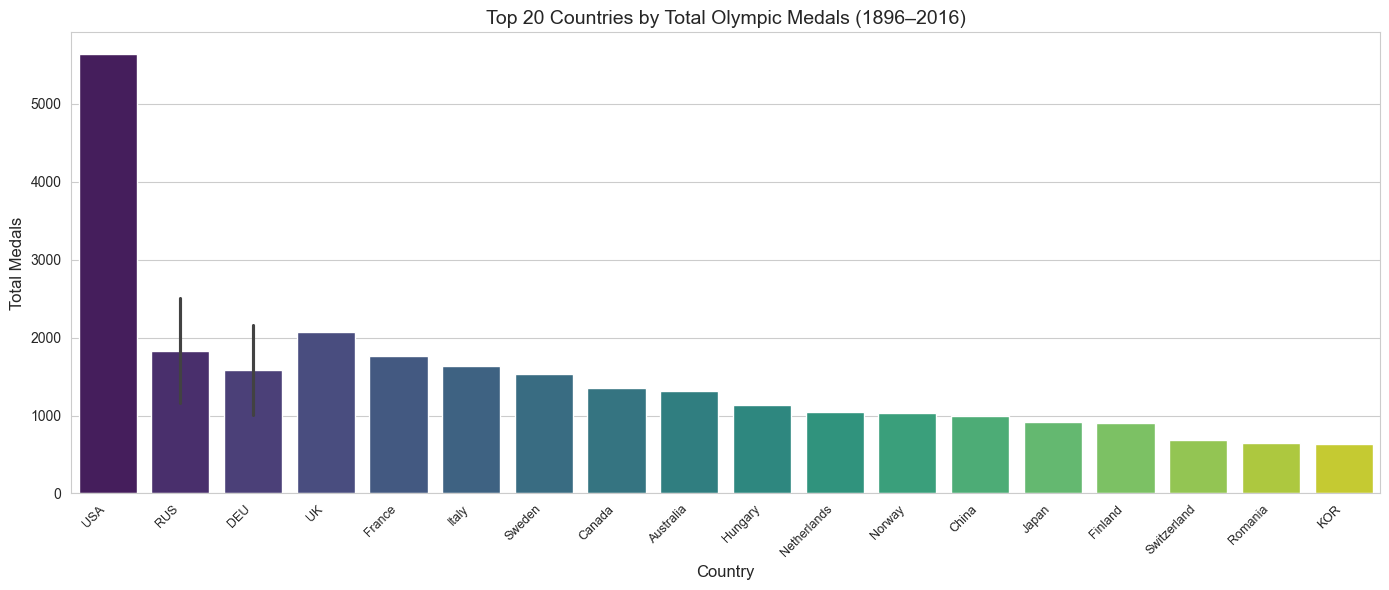


Top 10 Countries by Total Medals (out of 148 countries with medals):
       Country  Total_Medals
137        USA          5637
108        RUS          2503
34         DEU          2165
136         UK          2067
45      France          1767
63       Italy          1637
122     Sweden          1536
19      Canada          1352
5    Australia          1320
107        RUS          1165


In [ ]:
# Run Question 8 with all country markers
print("\n=== QUESTION 8: GLOBAL MAP WITH ALL COUNTRY MARKERS ===")
top_10, total_countries = q8_global_medal_map_folium()
print(f"\nTop 10 Countries by Total Medals (out of {total_countries} countries with medals):")
print(top_10[['Country', 'Total_Medals']])